# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***
**Advanced Lane Finding Project**

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Camera Calibration

Determining the camera calibration matrix and distortion coefficients is the first step toward correcting distortion in images. To obtain these we use a set of chessboard images and OpenCV's `calibrateCamera()` and `findChessboardCorners()` functions. Chessboard corners are detected in each image using `findChessboardCorners()` and are stored in the `img_points` array. For each set of `img_points` found a corresponding set of 3D points representing the position of the corner in the world coordinate space is kept in `obj_points`. These `obj_points` and `img_points` are then fed to `calibrateCamera()` to obtain our calibration matrix and distortion coefficients. Given an image, the matrix, and the distortion coefficients, OpenCV's `undistort()` can then be used to correct for distortion on any image taken with that camera and lens.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import project_data
import camera
%matplotlib inline

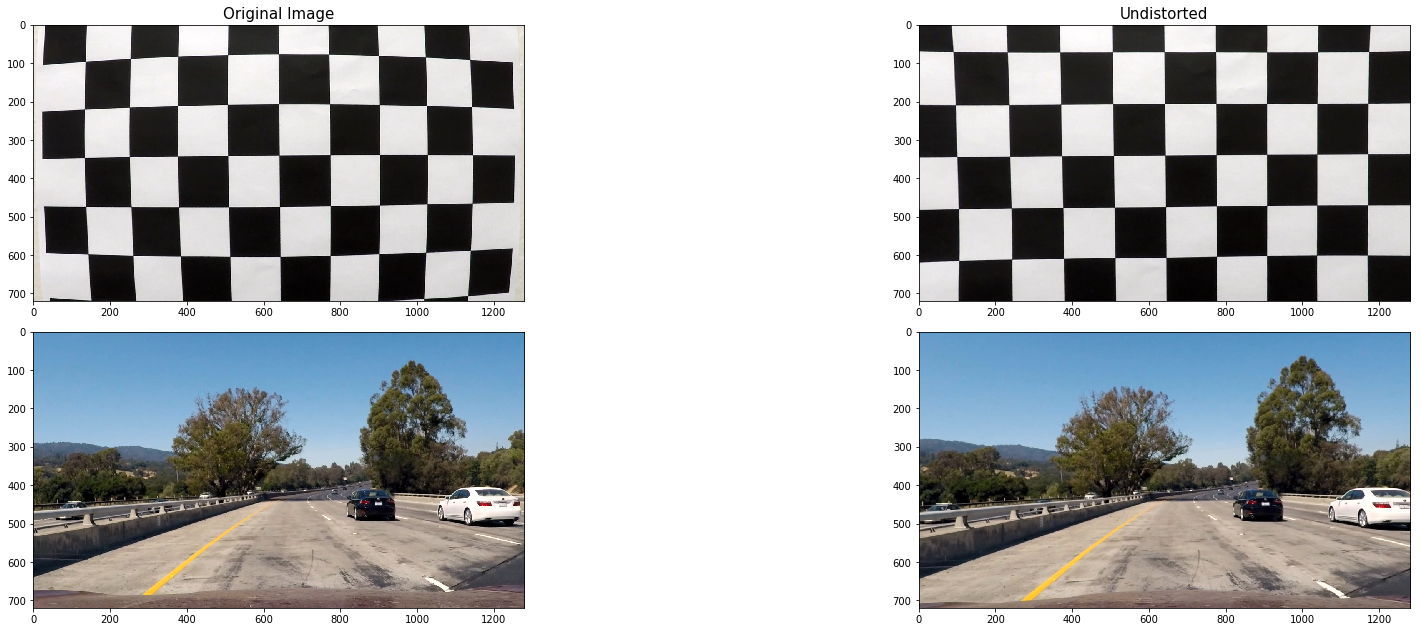

In [7]:
#
# Read in images
# calibration1.jpg is a chessboard. test3.jpg is an
# image of a road.  
img1 = cv2.imread('camera_cal/calibration1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('test_images/test1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

#
# calibrate() function is in camera.py
#
mtx, dist = camera.calibrate()

#
# Using the matrix and coefficents, undistort the images. 
#
undist1 = cv2.undistort(img1, mtx, dist, None, mtx)
undist2 = cv2.undistort(img2, mtx, dist, None, mtx)

#
# Display images.
#
f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
axes[0, 0].imshow(img1)
axes[0, 0].set_title('Original Image', fontsize=15)
axes[0, 1].imshow(undist1)
axes[0, 1].set_title('Undistorted', fontsize=15)
axes[1, 0].imshow(img2)
axes[1, 1].imshow(undist2)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

avg_left_lines = []
avg_right_lines = []

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

            
def draw_lines(img, lines, color=[255, 0, 0], thickness=2, roi_topY=0):
    global avg_right_lines
    global avg_left_lines
    
    #
    # The slope and y-intercept are averaged over
    # the last x frames goverened by this number
    #
    AVG_OVER_X_LAST_FRAMES = 10
    
    #
    # Slopes outside of this tolerance are ignored.
    #
    SLOPE_TOLERANCE = 0.10
    
    #
    # The middle of the frame is used as the
    # dividing line between left and right sides
    # of the lane.
    #
    mid_image = img.shape[1] / 2

    left_lane_points  = []
    right_lane_points = []
    if lines is not None:
        #
        # loop through all lines and split into left
        # and right lane points
        #
        for line in lines:
            for x1,y1,x2,y2 in line:
                #
                # Split the lane lines into right and left
                # using the center of the image as the
                # dividing line.
                #
                if x1 < mid_image:
                    left_lane_points.append((x1,y1))
                    left_lane_points.append((x2,y2))                
                else:
                    right_lane_points.append((x1,y1))
                    right_lane_points.append((x2,y2))

    #
    # our max Y will be the bottom of the screen
    # minY is passed in.
    #
    maxY = img.shape[0]
    minY = roi_topY    

    #
    # Draw the left lane line. OpenCV's fitLine will calculate a line
    # minimizing the distance using a least-squares method.
    #
    if len(left_lane_points) > 0:
        [vx, vy, x, y] = cv2.fitLine(np.array(left_lane_points), cv2.DIST_L2, 0, 0.01, 0.01)
    
        #
        # Calculate the slope and the y-intercept.
        #    
        slope = vy / vx
        y_intercept = y - (slope * x)
        if len(avg_left_lines) > 0:
            avg_slope, avg_y_intercept = np.mean(avg_left_lines, axis=0)
            if abs(avg_slope - slope) < SLOPE_TOLERANCE:
                avg_left_lines.append([slope, y_intercept])
        else:
            avg_left_lines.append([slope, y_intercept])
            
    
    if len(avg_left_lines) > AVG_OVER_X_LAST_FRAMES:
        avg_left_lines.pop(0)

    avg_slope, avg_y_intercept = np.mean(avg_left_lines, axis=0)
    minX = (minY - avg_y_intercept) / avg_slope
    maxX = (maxY - avg_y_intercept) / avg_slope
    cv2.line(img, (minX, minY), (maxX, maxY), color, thickness)

    #
    # Draw the right lane line in the same manner.
    #
    if len(right_lane_points) > 0:
        [vx, vy, x, y] = cv2.fitLine(np.array(right_lane_points), cv2.DIST_L2, 0, 0.01, 0.01)
        slope = vy / vx
        y_intercept = y - (slope * x)
        if len(avg_right_lines) > 0:
            avg_slope, avg_y_intercept = np.mean(avg_right_lines, axis=0)
            if abs(avg_slope - slope) < SLOPE_TOLERANCE:
                avg_right_lines.append([slope, y_intercept])
        else:
            avg_right_lines.append([slope, y_intercept])
    
    if len(avg_right_lines) > AVG_OVER_X_LAST_FRAMES:
        avg_right_lines.pop(0)

    avg_slope, avg_y_intercept = np.mean(avg_right_lines, axis=0)
    minX = (minY - avg_y_intercept) / avg_slope
    maxX = (maxY - avg_y_intercept) / avg_slope
    cv2.line(img, (minX, minY), (maxX, maxY), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def find_lanes(img, rho, theta, threshold, min_line_len, max_line_gap, roi_topY):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with lane lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, [255, 0, 0], 7, roi_topY)
    return line_img


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
images = os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

canny_high           = 250
canny_low            = 235
min_line_length      = 13
max_line_gap         = 15
gaussian_kernel_size = 5
hough_threshold      = 1
hough_rho            = 1
theta                = np.pi/180


if not os.path.isdir('test_images_output'):
    os.makedirs('test_images_output')

for filename in images:
    avg_left_lines = []
    avg_right_lines = []
    
    #
    # Read in the image file
    #
    image = mpimg.imread('test_images/' + filename, 1)
    h, w, _ = image.shape

    #
    # convert to grayscale, blur with a gaussian blur, and
    # perform a canny edge detection
    #
    gray = grayscale(image)
    blurred = gaussian_blur(gray, gaussian_kernel_size)
    canny_edges = canny(blurred, canny_low, canny_high)

    #
    # mask a region of interest for the image based on the
    # normalized coordinates
    #
    norm_roi_points = [(0.1344, 0.9292), (0.4609, 0.625), (0.557, 0.625), (0.9375, 0.9292)]
    roi_points = []
    for x, y in norm_roi_points:
        roi_points.append((x*w, y*h))
    roi = np.array([roi_points], dtype=np.int32)
    masked = region_of_interest(canny_edges, roi)


    #
    # find hough lines and draw over the original image
    #
    roi_topY = int(norm_roi_points[1][1] * h)
    lanes = find_lanes(masked, hough_rho,  np.pi/180, hough_threshold, min_line_length, max_line_gap, roi_topY )
    out_image = weighted_img(lanes, image)
    out_image = cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('test_images_output/' + filename, out_image)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def reset_averages():
    global avg_right_lines
    global avg_left_lines
    global frame
    avg_right_lines = []
    avg_left_lines = []
    frame = 0
    
def process_image(image):
    global frame    
    frame +=1
    
    canny_high           = 250
    canny_low            = 235
    min_line_length      = 100
    max_line_gap         = 160
    gaussian_kernel_size = 9
    hough_threshold      = 50
    hough_rho            = 1
    theta                = np.pi/180
    
    
    #
    # convert to grayscale, blur with a gaussian blur, and
    # perform a canny edge detection
    #
    gray = grayscale(image)
    equalized = cv2.equalizeHist(gray)
    blurred = gaussian_blur(equalized, gaussian_kernel_size)
    canny_edges = canny(blurred, canny_low, canny_high)

    #
    # mask a region of interest for the image based on the
    # normalized coordinates
    #
    norm_roi_points = [(0.1344, 0.9292), (0.4609, 0.625), (0.557, 0.625), (0.9375, 0.9292)]
    roi_points = []
    h, w, _ = image.shape
    for x, y in norm_roi_points:
        roi_points.append((x*w, y*h))
    roi = np.array([roi_points], dtype=np.int32)
    masked = region_of_interest(canny_edges, roi)


    #
    # find hough lines and draw over the original image
    #
    roi_topY = int(norm_roi_points[1][1] * h)
    lanes = find_lanes(masked, hough_rho,  np.pi/180, hough_threshold, min_line_length, max_line_gap, roi_topY )
    result = weighted_img(lanes, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
reset_averages()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
reset_averages()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,7)
clip3 = VideoFileClip('test_videos/challenge.mp4')
reset_averages()
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))